# Group 3 - Assigment 3

In [1]:
import pandas as pd
import networkx as nx
import nxviz as nv
from pandasql import sqldf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#work file
data = pd.read_csv("data/soc-redditHyperlinks-title.tsv", sep='\t')
len(data)

571927

In [114]:
def get_degree(G):
    degrees = [len(list(G.neighbors(n))) for n in G.nodes()]
    return degrees

def mark_nodes(size):
    nodes = []
    for n in N.nodes():
        if (len(list(N.neighbors(n)))<=size):
            nodes.append(n)
    return nodes

def mark_nodes_by_repetition(G,size):
    nodes = [n for n,d in G.nodes(data=True) if d['LINK_SENTIMENT']>=size]
    return nodes

def copy_sentiment_to_node(G):
    for x,y,d in G.edges(data=True):
        G.nodes[x]['LINK_SENTIMENT'] = d['LINK_SENTIMENT']
    for x,d in G.nodes(data=True):
        if len(d)<1:
            G.nodes[x]['LINK_SENTIMENT'] = 0
        

In [4]:
data.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
0,rddtgaming,rddtrust,1u4pzzs,2013-12-31 16:39:18,1,"25.0,23.0,0.76,0.0,0.44,0.12,0.12,4.0,4.0,0.0,..."
1,xboxone,battlefield_4,1u4tmfs,2013-12-31 17:59:11,1,"100.0,88.0,0.78,0.02,0.08,0.13,0.07,16.0,16.0,..."
2,ps4,battlefield_4,1u4tmos,2013-12-31 17:59:40,1,"100.0,88.0,0.78,0.02,0.08,0.13,0.07,16.0,16.0,..."
3,fitnesscirclejerk,leangains,1u50xfs,2013-12-31 19:01:56,1,"49.0,43.0,0.775510204082,0.0,0.265306122449,0...."
4,fitnesscirclejerk,lifeprotips,1u51nps,2013-12-31 21:02:28,1,"14.0,14.0,0.785714285714,0.0,0.428571428571,0...."


In [5]:
data_neg = data[data.LINK_SENTIMENT<0]
len(data_neg)

61140

In [6]:
data_neg.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
16,subredditdrama,nfl,1u58yq,2013-12-31 21:59:32,-1,"165.0,135.0,0.781818181818,0.0,0.0666666666667..."
20,libertyworldproblems,bitcoin,1u5c58,2014-01-01 13:56:53,-1,"307.0,253.0,0.785016286645,0.00325732899023,0...."
52,shitstatistssay,foodforthought,1u5u7e,2014-01-01 07:01:10,-1,"275.0,231.0,0.807272727273,0.0,0.0290909090909..."
69,childfree,adviceanimals,1u635q,2014-01-01 11:06:32,-1,"149.0,128.0,0.812080536913,0.0,0.134228187919,..."
80,levantinewar,worldpolitics,1u66wi,2014-01-01 10:48:53,-1,"209.0,177.0,0.827751196172,0.0,0.0622009569378..."


In [7]:
data_ext = data_neg[['SOURCE_SUBREDDIT','TARGET_SUBREDDIT','LINK_SENTIMENT']].groupby(['SOURCE_SUBREDDIT','TARGET_SUBREDDIT'])['LINK_SENTIMENT'].sum().reset_index()
len(data_ext)

29257

In [8]:
data_ext.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,LINK_SENTIMENT
0,1200isjerky,1200isplenty,-1
1,1200isjerky,dataisbeautiful,-1
2,1509,gaming,-1
3,16eralert,kappa,-2
4,18bfriendzonest,askreddit,-1


In [9]:
all_source = data['SOURCE_SUBREDDIT'].unique()
neg_source = data_ext['SOURCE_SUBREDDIT'].unique()

In [10]:
perc = (neg_source.size/all_source.size)*100
print("All negatives come from only "+str(perc)+"% of all subreddits")

All negatives come from only 14.228172559789451% of all subreddits


In [86]:
N=nx.Graph()
N=nx.from_pandas_edgelist(data_ext, 'SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT','LINK_SENTIMENT')

In [12]:
len(N.nodes())

9136

In [13]:
len(N.edges())

28610

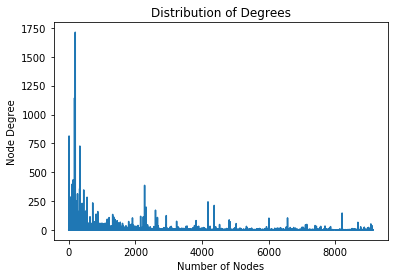

In [14]:
degrees = get_degree(N)
plt.xlabel("Number of Nodes")
plt.ylabel("Node Degree")
plt.title("Distribution of Degrees")
plt.plot(degrees)

In [78]:
nodes = mark_nodes(3)
len(nodes)

7015

In [79]:
N.remove_nodes_from(nodes)

In [80]:
len(N.nodes())

2121

In [81]:
len(N.edges())

19905

In [87]:
nodes = mark_nodes(3)
while len(nodes)!=0:
    N.remove_nodes_from(nodes)
    nodes = mark_nodes(3)

In [88]:
len(N.nodes())

1875

In [89]:
degrees = get_degree(N)
len(degrees)

1875

In [90]:
dec = nx.degree_centrality(N)
len(dec)

1875

Text(0, 0.5, 'Degree of Centrality')

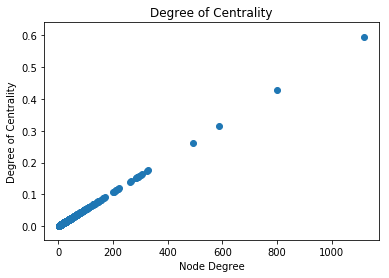

In [91]:
plt.scatter(degrees,dec.values())
plt.title("Degree of Centrality")
plt.xlabel("Node Degree")
plt.ylabel("Degree of Centrality")

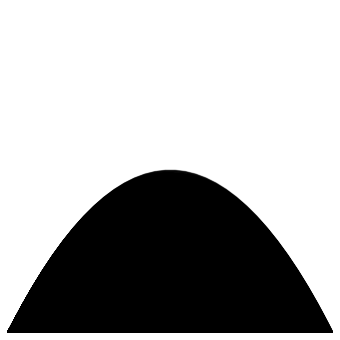

In [24]:
gf = nv.ArcPlot(N)
gf.draw()

In [124]:
copy_sentiment_to_node(N)
nodes = mark_nodes_by_repetition(N,-1)
len(nodes)

1648

In [125]:
 N.remove_nodes_from(nodes)

In [127]:
len(N.nodes())

227

In [128]:
len(N.edges())

1068

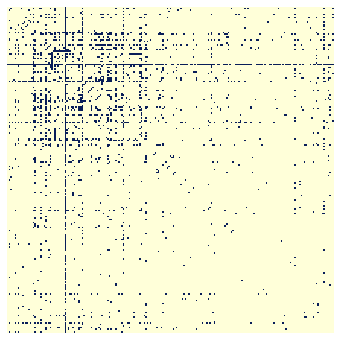

In [133]:
gf = nv.MatrixPlot(N)
gf.draw()
plt.show()

In [130]:
nodes = mark_nodes(0)
while len(nodes)!=0:
    N.remove_nodes_from(nodes)
    nodes = mark_nodes(0)

In [132]:
len(N.nodes())

215

In [135]:
A = nx.to_numpy_matrix(N)
A

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 1.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]])

In [141]:
for n in N.nodes():
    N.nodes[n]['degree'] = len(list(N.neighbors(n)))

TypeError: unhashable type: 'dict'

In [138]:
gf = nv.CircosPlot(N, node_grouping='degree',node_color='degree', node_order='degree')
gf.draw()
plt.show()

KeyError: 'degree'

In [26]:
#########################################################################################################

In [27]:
data_props = data[['LINK_SENTIMENT','PROPERTIES']][0:10000]
words = []
for index, row in data_props.iterrows():
    word = row['PROPERTIES'].split(',')[7]
    words.append(word)
words = pd.DataFrame(words)
data_props['WORDS'] = words
data_props_w = data_props[['LINK_SENTIMENT','WORDS']]

In [28]:
data_props_w.head()

,LINK_SENTIMENT,WORDS
0,1,4.0
1,1,16.0
2,1,16.0
3,1,8.0
4,1,2.0


In [29]:
dist_n = sqldf("select count(LINK_SENTIMENT) as LS, WORDS from data_props_w where LINK_SENTIMENT<1 group by WORDS order by WORDS asc")
dist_n.head()

,LS,WORDS
0,27,10.0
1,33,11.0
2,37,12.0
3,27,13.0
4,35,14.0


In [30]:
dist_p = sqldf("select count(LINK_SENTIMENT) as LS, WORDS from data_props_w where LINK_SENTIMENT>0 group by WORDS order by WORDS")
dist_p.head()

,LS,WORDS
0,2,1.0
1,587,10.0
2,542,11.0
3,563,12.0
4,499,13.0


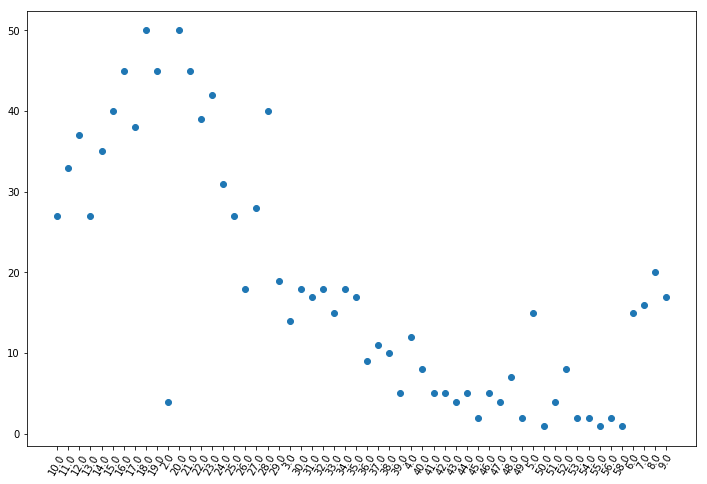

In [31]:
plt.figure(figsize=(12,8))
plt.xticks(rotation=60)
plt.scatter(dist_n.WORDS,dist_n.LS)

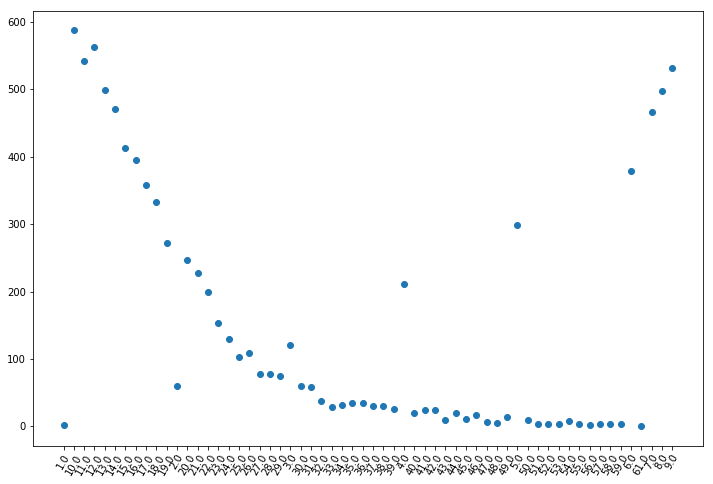

In [32]:
plt.figure(figsize=(12,8))
plt.xticks(rotation=60)
plt.scatter(dist_p.WORDS,dist_p.LS)

In [33]:
data.shape

(571927, 6)

In [34]:
data.dtypes

SOURCE_SUBREDDIT    object
TARGET_SUBREDDIT    object
POST_ID             object
TIMESTAMP           object
LINK_SENTIMENT       int64
PROPERTIES          object
dtype: object

In [35]:
data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'], format="%Y-%m-%d %H:%M:%S")
data.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
0,rddtgaming,rddtrust,1u4pzzs,2013-12-31 16:39:18,1,"25.0,23.0,0.76,0.0,0.44,0.12,0.12,4.0,4.0,0.0,..."
1,xboxone,battlefield_4,1u4tmfs,2013-12-31 17:59:11,1,"100.0,88.0,0.78,0.02,0.08,0.13,0.07,16.0,16.0,..."
2,ps4,battlefield_4,1u4tmos,2013-12-31 17:59:40,1,"100.0,88.0,0.78,0.02,0.08,0.13,0.07,16.0,16.0,..."
3,fitnesscirclejerk,leangains,1u50xfs,2013-12-31 19:01:56,1,"49.0,43.0,0.775510204082,0.0,0.265306122449,0...."
4,fitnesscirclejerk,lifeprotips,1u51nps,2013-12-31 21:02:28,1,"14.0,14.0,0.785714285714,0.0,0.428571428571,0...."


In [36]:
data.isnull().any()

SOURCE_SUBREDDIT    False
TARGET_SUBREDDIT    False
POST_ID             False
TIMESTAMP           False
LINK_SENTIMENT      False
PROPERTIES          False
dtype: bool

In [37]:
data.columns

Index(['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT', 'POST_ID', 'TIMESTAMP',
       'LINK_SENTIMENT', 'PROPERTIES'],
      dtype='object')

In [38]:
uniqueSource = data['SOURCE_SUBREDDIT'].unique()
uniqueSource.size

43695

In [39]:
uniqueTarget = data['TARGET_SUBREDDIT'].unique()
uniqueTarget.size

26888

### Grouping all SUBREDDITS by SOURCE AND TARGET WITH SENTIMENT COUNT

In [40]:
data_group_neg = sqldf("select SOURCE_SUBREDDIT,TARGET_SUBREDDIT, sum(LINK_SENTIMENT) as NEG_SENT from data where LINK_SENTIMENT<1 group by SOURCE_SUBREDDIT,TARGET_SUBREDDIT order by NEG_SENT")
data_group_neg.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,NEG_SENT
0,shitredditsays,twoxchromosomes,-107
1,evenwithcontext,askreddit,-97
2,amrsucks,againstmensrights,-89
3,subredditdrama,relationships,-84
4,subredditdrama,askreddit,-81


In [41]:
len(data_group_neg)

29257

In [42]:
data_group_pos = sqldf("select SOURCE_SUBREDDIT,TARGET_SUBREDDIT, sum(LINK_SENTIMENT) as POS_SENT from data where LINK_SENTIMENT=1 group by SOURCE_SUBREDDIT,TARGET_SUBREDDIT order by POS_SENT desc")
data_group_pos.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POS_SENT
0,moronicmondayandroid,android,478
1,goodshibe,dogecoin,299
2,nightlypick,hockey,295
3,titlegore,todayilearned,279
4,switcharoo,pics,245


In [43]:
len(data_group_pos)

221593

In [44]:
data_group = pd.merge(data_group_neg, data_group_pos,  how='right', left_on=['SOURCE_SUBREDDIT','TARGET_SUBREDDIT'], right_on = ['SOURCE_SUBREDDIT','TARGET_SUBREDDIT'])
data_group['NEG_SENT'].fillna(0,inplace=True)
data_group['POS_SENT'].fillna(0,inplace=True)
data_group["TOTAL_SENT"]=data_group.POS_SENT-data_group.NEG_SENT
data_group.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,NEG_SENT,POS_SENT,TOTAL_SENT
0,shitredditsays,twoxchromosomes,-107.0,118,225.0
1,evenwithcontext,askreddit,-97.0,190,287.0
2,amrsucks,againstmensrights,-89.0,91,180.0
3,subredditdrama,relationships,-84.0,100,184.0
4,subredditdrama,askreddit,-81.0,130,211.0


In [45]:
len(data_group)

221593

In [46]:
len(data_group[data_group.TOTAL_SENT<10])

213825

In [47]:
sample_data = data_group[data_group.TOTAL_SENT>=10]
print ("After removing SUBREDITS with a repetition of 10: Remaining Connections = "+str(len(sample_data)))

After removing SUBREDITS with a repetition of 10: Remaining Connections = 7768


In [48]:
sample_data.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,NEG_SENT,POS_SENT,TOTAL_SENT
0,shitredditsays,twoxchromosomes,-107.0,118,225.0
1,evenwithcontext,askreddit,-97.0,190,287.0
2,amrsucks,againstmensrights,-89.0,91,180.0
3,subredditdrama,relationships,-84.0,100,184.0
4,subredditdrama,askreddit,-81.0,130,211.0


In [49]:
nodes = pd.unique(sample_data[['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT']].values.ravel('K'))
len(nodes)

3375

In [50]:
G=nx.DiGraph()
G=nx.from_pandas_edgelist(sample_data, 'SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT', edge_attr='TOTAL_SENT')  

In [51]:
len(G.edges)

7328

In [52]:
len(G.nodes)

3375

In [53]:
#Most noisy using degree of centrality
deg_cent = nx.degree_centrality(G)
max_dc = max(deg_cent.values())
prolific_collaborators = [n for n, dc in deg_cent.items() if dc ==max_dc]
prolific_collaborators

['subredditdrama']

In [54]:
tempneg = sqldf("select strftime('%Y',TIMESTAMP) as Year, count(LINK_SENTIMENT) as LINK_SENTIMENT from data where SOURCE_SUBREDDIT='"+prolific_collaborators[0]+"' and LINK_SENTIMENT<0 group by Year")
temppos = sqldf("select strftime('%Y',TIMESTAMP) as Year, count(LINK_SENTIMENT) as LINK_SENTIMENT from data where SOURCE_SUBREDDIT='"+prolific_collaborators[0]+"' and LINK_SENTIMENT>0 group by Year")

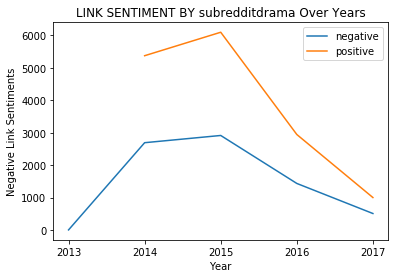

In [55]:
plt.plot(tempneg.Year,tempneg.LINK_SENTIMENT, label="negative")
plt.plot(temppos.Year,temppos.LINK_SENTIMENT, label="positive")
plt.title("LINK SENTIMENT BY "+str(prolific_collaborators[0])+" Over Years")
plt.xlabel("Year")
plt.ylabel("Negative Link Sentiments")
plt.legend()

In [56]:
temppos = sqldf("select strftime('%Y',TIMESTAMP) as Year, TARGET_SUBREDDIT, sum(LINK_SENTIMENT) as LINK_SENTIMENT from data where SOURCE_SUBREDDIT='"+prolific_collaborators[0]+"' and Year='2015' and LINK_SENTIMENT<0 group by TARGET_SUBREDDIT order by LINK_SENTIMENT")
temppos.head()

,Year,TARGET_SUBREDDIT,LINK_SENTIMENT
0,2015,relationships,-29
1,2015,adviceanimals,-25
2,2015,askreddit,-25
3,2015,movies,-25
4,2015,kotakuinaction,-24


In [57]:
temppos = sqldf("select strftime('%Y',TIMESTAMP) as Year, SOURCE_SUBREDDIT, sum(LINK_SENTIMENT) as LINK_SENTIMENT from data where TARGET_SUBREDDIT='relationships' and Year='2015' and LINK_SENTIMENT<0 group by SOURCE_SUBREDDIT order by LINK_SENTIMENT")

In [58]:
temppos.head()

,Year,SOURCE_SUBREDDIT,LINK_SENTIMENT
0,2015,subredditdrama,-29
1,2015,bestof,-19
2,2015,mensrights,-12
3,2015,thebluepill,-9
4,2015,worstof,-7


In [59]:
dataY = sqldf("select SOURCE_SUBREDDIT,TARGET_SUBREDDIT, count(LINK_SENTIMENT) as LINK_SENTIMENT from data where (TARGET_SUBREDDIT like 'relationships') group by SOURCE_SUBREDDIT order by LINK_SENTIMENT desc")

/Applications/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


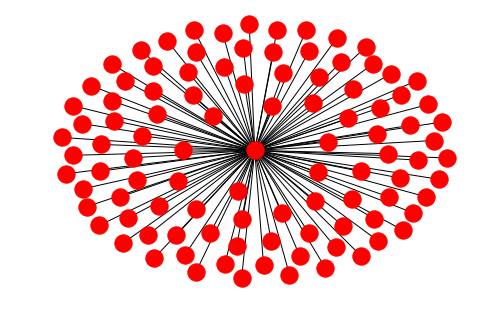

In [60]:
X = nx.DiGraph()
dataX = dataY[(dataY.SOURCE_SUBREDDIT=='relationships') | (dataY.TARGET_SUBREDDIT=='relationships')][0:100]
X=nx.from_pandas_edgelist(dataX, 'SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT')
nx.draw(X)

In [61]:
temppos = sqldf("select strftime('%Y',TIMESTAMP) as Year, SOURCE_SUBREDDIT, sum(LINK_SENTIMENT) as LINK_SENTIMENT from data where TARGET_SUBREDDIT='relationships' and Year='2015' and LINK_SENTIMENT>0 group by SOURCE_SUBREDDIT order by LINK_SENTIMENT desc")

In [62]:
temppos.head()

,Year,SOURCE_SUBREDDIT,LINK_SENTIMENT
0,2015,subredditdrama,46
1,2015,bestof,33
2,2015,thebluepill,15
3,2015,childfree,12
4,2015,titlegore,10


In [63]:
neg_leader = sqldf("select SOURCE_SUBREDDIT, sum(NEG_SENT) as NEG_SENT from sample_data group by SOURCE_SUBREDDIT order by NEG_SENT")
neg_leader.head()

,SOURCE_SUBREDDIT,NEG_SENT
0,subredditdrama,-5917.0
1,bestof,-2573.0
2,drama,-1322.0
3,circlebroke2,-1301.0
4,shitpost,-1009.0


In [64]:
neg_leader = neg_leader[0:100]

In [65]:
srd = G.subgraph(neg_leader.SOURCE_SUBREDDIT)
for n, d in srd.nodes(data=True):
    # Calculate the degree of each node: G.node[n]['degree']
    srd.node[n]['degree'] = nx.degree(srd, n)

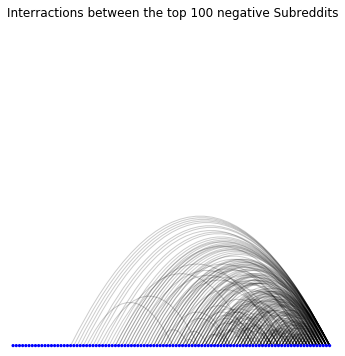

In [66]:
t = nv.ArcPlot(graph=srd, node_order='degree', node_label=True)
t.draw()
plt.title("Interractions between the top 100 negative Subreddits")
plt.show()

In [67]:
neg_leader = sqldf("select SOURCE_SUBREDDIT, sum(POS_SENT) as POS_SENT from sample_data group by SOURCE_SUBREDDIT order by POS_SENT desc")
neg_leader.head()

,SOURCE_SUBREDDIT,POS_SENT
0,bestof,12667
1,subredditdrama,11934
2,shitredditsays,4998
3,titlegore,4876
4,shitpost,4207


In [68]:
neg_leader = neg_leader[0:100]
srd = G.subgraph(neg_leader.SOURCE_SUBREDDIT)
for n, d in srd.nodes(data=True):
    # Calculate the degree of each node: G.node[n]['degree']
    srd.node[n]['degree'] = nx.degree(srd, n)

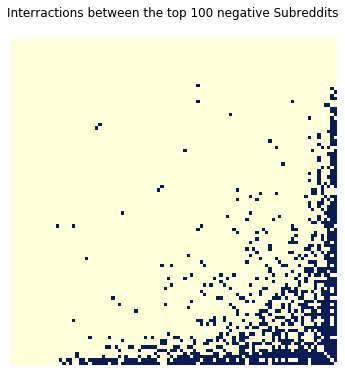

In [69]:
t = nv.MatrixPlot(graph=srd, node_order='degree', node_color='degree')
t.draw()
plt.title("Interractions between the top 100 negative Subreddits")
plt.show()

In [70]:
def largest_closed_community(G,size):
    mcs = []
    for clique in nx.find_cliques(G):
        if len(clique)==size:
            mcs.append(clique)
    return mcs 

size_of_cliques = range(3,22)
num_of_cliques = []
for n in size_of_cliques:
    size = len(largest_closed_community(G,n))
    if (size!=0):
        num_of_cliques.append(size)

Text(0, 0.5, 'Number of Subgraphs')

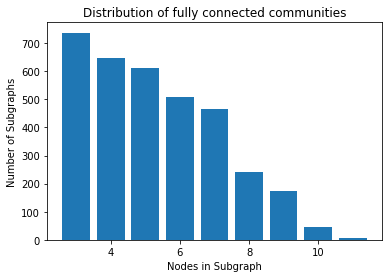

In [71]:
size_of_cliques = range(3,len(num_of_cliques)+3)
size_of_cliques=list(size_of_cliques)
plt.bar(size_of_cliques,num_of_cliques)
plt.title("Distribution of fully connected communities")
plt.xlabel("Nodes in Subgraph")
plt.ylabel("Number of Subgraphs")

In [72]:
large_c = largest_closed_community(G,max(size_of_cliques))
node_list = []
for _edge in large_c:
    for _node in _edge:
        if _node not in node_list:
            node_list.append(_node)
sub_G=G.subgraph(node_list) 
sub_G.nodes

NodeView(('conspiracy', 'todayilearned', 'the_donald', 'worldnews', 'politics', 'news', 'shitamericanssay', 'bestof', 'subredditdrama', 'shitstatistssay', 'anarcho_capitalism', 'libertarian', 'enoughlibertarianspam', 'socialism'))

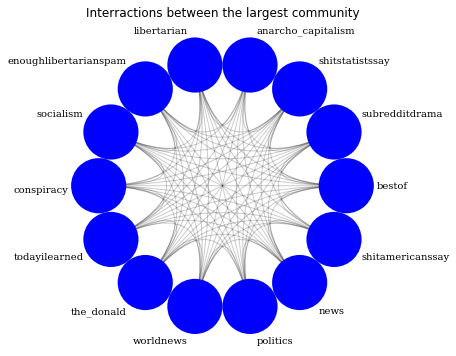

In [73]:
c = nv.CircosPlot(sub_G,node_labels=True)
# Draw the CircosPlot to the screen
c.draw()
plt.title("Interractions between the largest community")
plt.show()


/Applications/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


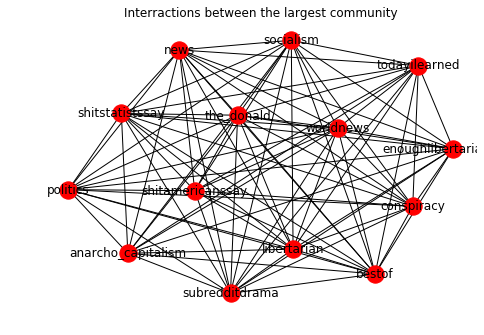

In [74]:
nx.draw(sub_G,with_labels = True)
plt.title("Interractions between the largest community")
plt.show()

### Top 5 target subreddit

In [75]:
top5Target = data.groupby('TARGET_SUBREDDIT')['POST_ID'].count().reset_index(name='count').sort_values(by='count',ascending=False).head(5)
top5Target

,TARGET_SUBREDDIT,count
1635,askreddit,19293
17872,pics,9799
11293,iama,9752
24159,todayilearned,8753
9232,funny,8731


Source to positve target:  (510787, 6)
Source to negative target:  (61140, 6)
Negative % =  10.690175494424988


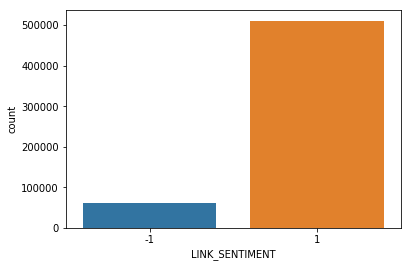

In [76]:
towardPositive = data[data.LINK_SENTIMENT==1]
towardNegative = data[data.LINK_SENTIMENT==-1]
print("Source to positve target: ", towardPositive.shape)
print("Source to negative target: ", towardNegative.shape)
print("Negative % = ", towardNegative.shape[0]*100/(towardPositive.shape[0] + towardNegative.shape[0]))
sns.countplot(x='LINK_SENTIMENT', data=data)

### Convert the data into graph model 
- vertex: subreddits
- edge: source and target subreddits

### Find clustering coefficient(global/local)
- Adjacency list
- Sort-Merge algorithm to find triangles and triads

### Find strongly connected components (similar subreddit)
- When there is a loop among all the nodes in a component
- Show the subreddits of same cluster

### Finding K-Core
- How sparse the graph is?

### Analysis of subreddit based on time
- When did this subreddit(i.e. askreddit) become popular?

### Is there any relationship between source and target subreddit when the LINK_SENTIMENT is negative?